![Roboflow Notebooks banner](https://camo.githubusercontent.com/aec53c2b5fb6ed43d202a0ab622b58ba68a89d654fbe3abab0c0cc8bd1ff424e/68747470733a2f2f696b2e696d6167656b69742e696f2f726f626f666c6f772f6e6f7465626f6f6b732f74656d706c6174652f62616e6e657274657374322d322e706e673f696b2d73646b2d76657273696f6e3d6a6176617363726970742d312e342e33267570646174656441743d31363732393332373130313934)

# Image Classification with DINOv2

DINOv2, released by Meta Research in April 2023, implements a self-supervised method of training computer vision models.

DINOv2 was trained using 140 million images without labels. The embeddings generated by DINOv2 can be used for classification, image retrieval, segmentation, and depth estimation. With that said, Meta Research did not release heads for segmentation and depth estimation.

In this guide, we are going to build an image classifier using embeddings from DINOv2. To do so, we will:

1. Load a folder of images
2. Compute embeddings for each image
3. Save all the embeddings in a file and vector store
4. Train an SVM classifier to classify images

We'll be using the [MIT Indoor Scene Recognition dataset](https://universe.roboflow.com/popular-benchmarks/mit-indoor-scene-recognition/) in this project, but you can use any labelled classification dataset you have.

By the end of this notebook, we'll have a classifier trained on our dataset.

Without further ado, let's begin!

## Import Packages

First, let's import the packages we will need for this project.

In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
#import cv2
import json
import glob
from tqdm.notebook import tqdm

## Load Data

In this guide, we're going to work with the [MIT Indoor Scene Recognition dataset](https://universe.roboflow.com/popular-benchmarks/mit-indoor-scene-recognition), hosted on Roboflow Universe. To download this dataset, you will need a [free Roboflow account](https://app.roboflow.com).

Let's download the dataset and create a dictionary that maps each image in our training dataset to its associated label.

In [2]:
import roboflow
import supervision as sv


In [3]:
cwd = os.getcwd()
cwd

'/workspaces/gc_quant_trading_research'

In [50]:
cwd = os.getcwd()

ROOT_DIR = os.path.join(cwd)

labels = {}

for folder in os.listdir(ROOT_DIR):
  try:
    print(folder)
    for file in os.listdir(os.path.join(ROOT_DIR, folder)):
        if file.endswith(".png"):
            full_name = os.path.join(ROOT_DIR, folder, file)
            labels[full_name] = folder
  except:
    pass

files = labels.keys()

README.md
now
notebooks
bull
dockerfile
all_embeddings.json
requirements.txt
Dinov2_classification_gc.ipynb
.git
bear
data


In [51]:
list(files)

['/workspaces/gc_quant_trading_research/now/Screenshot 2024-05-19 at 16.30.46.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 12.49.40.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 14.58.57.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 14.46.14.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 12.47.37.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 14.54.06.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 13.17.21.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 15.56.00.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 12.51.04.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 15.38.48.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19 at 15.17.11.png',
 '/workspaces/gc_quant_trading_research/bull/Screenshot 2024-05-19

In [52]:
# prompt: get data from dictionary files

values = [labels[key] for key in files]

## Load the Model and Compute Embeddings

To train our classifier, we need:

1. The embeddings associated with each image in our dataset, and;
2. The labels associated with each image.

To calculate embeddings, we'll use DINOv2. Below, we load the smallest DINOv2 weights and define functions that will load and compute embeddings for every image in a specified list.

We store all of our vectors in a dictionary that is saved to disk so we can reference them again if needed. Note that in production environments one may opt for using another data structure such as a vector embedding database (i.e. faiss) for storing embeddings.

In [53]:
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

dinov2_vits14.to(device)

transform_image = T.Compose([T.ToTensor(),
                             T.Resize((224, 224)),
                             #T.CenterCrop(224),
                             T.Normalize([0.5], [0.5])])

Using cache found in /home/codespace/.cache/torch/hub/facebookresearch_dinov2_main


In [54]:
def load_image(img: str) -> torch.Tensor:
    """
    Load an image and return a tensor that can be used as an input to DINOv2.
    """
    img = Image.open(img)

    transformed_img = transform_image(img)[:3].unsqueeze(0)

    return transformed_img

def compute_embeddings(files: list) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = {}

    with torch.no_grad():
      for i, file in enumerate(files):
        embeddings = dinov2_vits14(load_image(file).to(device))

        all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    return all_embeddings

## Compute Embeddings

The code below computes the embeddings for all the images in our dataset. This step will take a few minutes for the MIT Indoor Scene Recognition dataset. There are over 10,000 images in the training set that we need to pass through DINOv2.

In [55]:
embeddings = compute_embeddings(files)

In [ ]:
embedding_list = list(embeddings.values())
embedding_arr = np.array(embedding_list).reshape(-1, 384)

In [ ]:
embedding_arr

array([[-4.10856199,  1.25077176, -4.75899029, ..., -1.00706708,
        -0.5318839 ,  3.16503978],
       [-2.49476838,  1.12105143, -3.55495572, ...,  0.07029904,
        -0.30219498,  3.22422862],
       [-2.36415315,  0.91241473, -3.20919204, ..., -1.5124929 ,
        -0.37449324,  3.72332263],
       ...,
       [-3.31776071,  1.15417707, -4.01899862, ..., -0.93220258,
        -0.8403123 ,  3.65066624],
       [-4.55517006,  1.21726418, -5.1086998 , ...,  0.31251094,
        -0.85597515,  3.65354133],
       [-3.61212063,  1.49255478, -3.69711852, ...,  0.01162532,
        -0.52230209,  3.86196899]])

In [ ]:
# prompt: generate a 2d dimentional reduction of the embeddings with TSNE

from sklearn.manifold import TSNE

# Reduce dimensionality of the embeddings
tsne = TSNE(n_components=2)
tsne_embeddings = tsne.fit_transform(embedding_arr)


In [ ]:
# prompt: install umap and reduce dimension with umap
import numpy as np
import umap

# Initialize UMAP model
umap_model = umap.UMAP(n_components=2, random_state=42)

# Fit and transform the data to generate embeddings
umap_embeddings = umap_model.fit_transform(embedding_arr)


/home/codespace/.python/current/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [ ]:
# prompt: generate embedding plot with plotly

import plotly.express as px

fig = px.scatter(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], color=values, hover_name=files)
fig.show()



In [ ]:
fig = px.scatter(x=tsne_embeddings[:, 0], y=tsne_embeddings[:, 1], color=values, hover_name=files)
fig.show()

## Train a Classification Model

The embeddings we have computed can be used as an input in a classification model. For this guide, we will be using SVM, a linear classification model.

Below, we make lists of both all of the embeddings we have computed and their associated labels. We then fit our model using those lists.

In [ ]:
from sklearn import svm

clf = svm.SVC(gamma='scale')

y = [labels[file] for file in files]

embedding_list = list(embeddings.values())

clf.fit(np.array(embedding_list).reshape(-1, 384), y)

SVC()

## Classify an Image

We now have a classifier we can use to classify images!

Change the `input_file` value below to the path of a file in the `valid` or `test` directories in the image dataset with which we have been working.

Then, run the cell to classify the image.

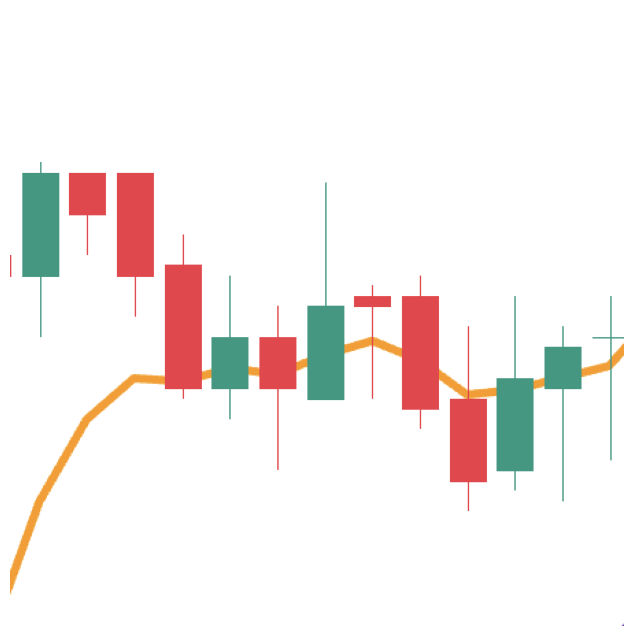


Predicted class: bull


In [ ]:
import cv2
input_file = "/workspaces/gc_quant_trading_research/now/Screenshot 2024-05-19 at 16.30.46.png"

new_image = load_image(input_file)

%matplotlib inline
sv.plot_image(image=cv2.imread(input_file), size=(8, 8))

with torch.no_grad():
    embedding = dinov2_vits14(new_image.to(device))

    prediction = clf.predict(np.array(embedding[0].cpu()).reshape(1, -1))

    print()
    print("Predicted class: " + prediction[0])